## Modeling Beta as an OU Process
### 2024.08.07

In these first few cells, we generate data using a step-function beta. 
Beta starts at 0.25 for 40 days, and then steps down to 0.12 for the remainder of the time series.

See the first visualiation 'SIRH Dynamics' for the generated data. 

In [1]:
from src.particle_filter.parameters import ModelParameters
from src.particle_filter.transition import (
    Transition,
    OUModel,
)
from jax.random import PRNGKey
import jax.numpy as jnp


days = 100

step_beta = [0.12 for _ in range(days)]
step_beta[:20] = [0.25 for _ in range(40)]

pop = 100000
infected = 0.05 * pop
susceptible = pop - infected
initial_state = jnp.array([susceptible, infected, 0, 0, 0, 0.3])
key = PRNGKey(0)

In [2]:
print(step_beta)

[0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12]


In [3]:
import paths
import os

config_path = os.path.join(paths.PF_DIR, "config.toml")

ou_model = OUModel(config_path)

det_output = [initial_state.copy()]
case_reports = [0]

In [4]:
def det_update(state, time_step):
    state = state.at[5].set(step_beta[time_step])
    update = ou_model.det_component(state, time_step)
    case_reports.append(update[4].item())
    state += update
    return state


for t in range(1, days):
    det_output.append(det_update(det_output[-1], t))

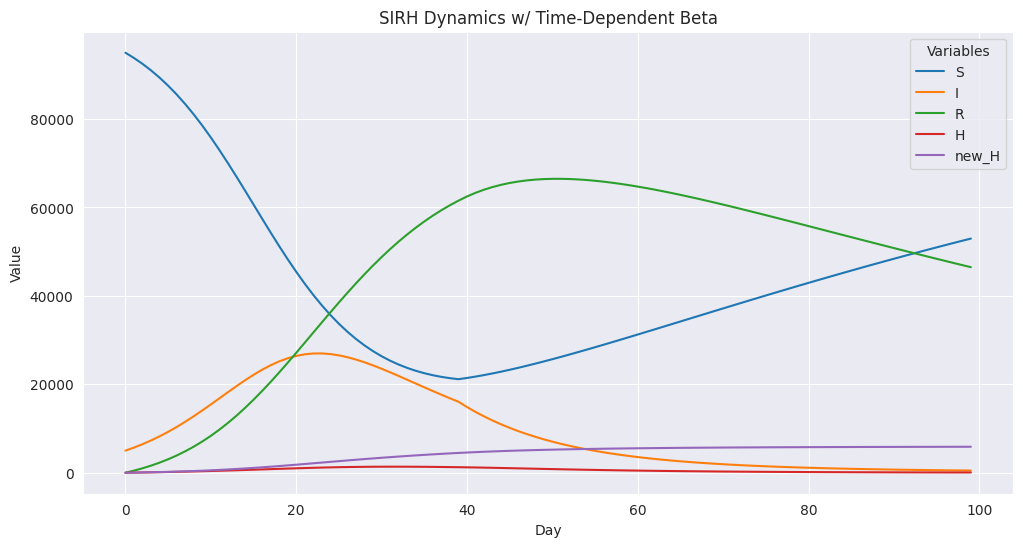

In [12]:
import numpy as np
import matplotlib.pyplot as plt


def plot_output(output):
    data = np.array(output)
    labels = ["S", "I", "R", "H", "new_H"]
    # Create a plot for each variable
    plt.figure(figsize=(12, 6))

    # for each day
    for i in range(data.shape[1] - 1):
        # plot each compartment
        plt.plot(range(data.shape[0]), data[:, i], label=labels[i])

    plt.title("SIRH Dynamics w/ Time-Dependent Beta")
    plt.xlabel("Day")
    plt.ylabel("Value")
    plt.legend(title="Variables")
    plt.show()


plot_output(det_output)

In [6]:
# obs_data is an array of the new hospitalizations from synthetic data
data = np.array(det_output)
print("new hospitalizations:", case_reports)

new hospitalizations: [0, 30.0, 34.125, 38.715877532958984, 43.795772552490234, 49.38006591796875, 55.47359085083008, 62.067596435546875, 69.13667297363281, 76.63590240478516, 84.49866485595703, 92.63532257080078, 100.93345642089844, 109.2597427368164, 117.4638900756836, 125.38450622558594, 132.8566436767578, 139.72039794921875, 145.8297882080078, 151.06097412109375, 155.31881713867188, 158.5413360595703, 160.70135498046875, 161.80567932128906, 161.8918914794922, 161.0234375, 159.28379821777344, 156.7702178955078, 153.58775329589844, 149.84397888183594, 145.64459228515625, 141.0900421142578, 136.27322387695312, 131.27786254882812, 126.17792510986328, 121.03734588623047, 115.91033172607422, 110.84198760986328, 105.86900329589844, 101.02058410644531, 96.31927490234375, 89.13272857666016, 82.51192474365234, 76.4138412475586, 70.79803466796875, 65.626708984375, 60.86460494995117, 56.4789924621582, 52.43952560424805, 48.71815490722656, 45.28898620605469, 42.12815475463867, 39.21371078491211

## Estimating Beta with our Particle Filter

We run a PF over the generated data. Settings were configured in `config.toml`.

- Beta prior = uniform draw from [0.10, 0.35]
- Number of particles = 300
- dt = 1.0
- infected comparment prior: uniform draw from [1, 0.08*population]
- normal logpdf likelihood with scale=100

In [7]:
from src.particle_filter.initialize import initialize_particle_filter

pf_algo = initialize_particle_filter(
    state_population=pop, location_code="04", target_date="2047-10-28", runtime=days
)

In [8]:
_, states, all_resamples, all_weights = pf_algo.run(observation_data=case_reports)

Running Particle Filter: 100%|██████████| 100/100 [02:45<00:00,  1.66s/it]


In [10]:
true_data = data
true_data = true_data.T
true_data[5, :] = step_beta[:100]
true_data.shape

(6, 100)

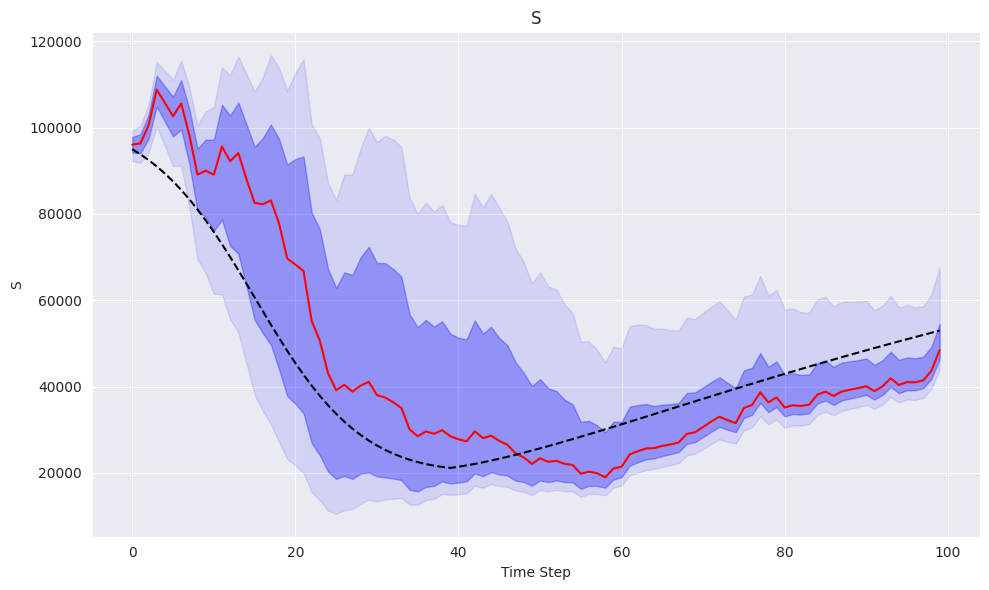

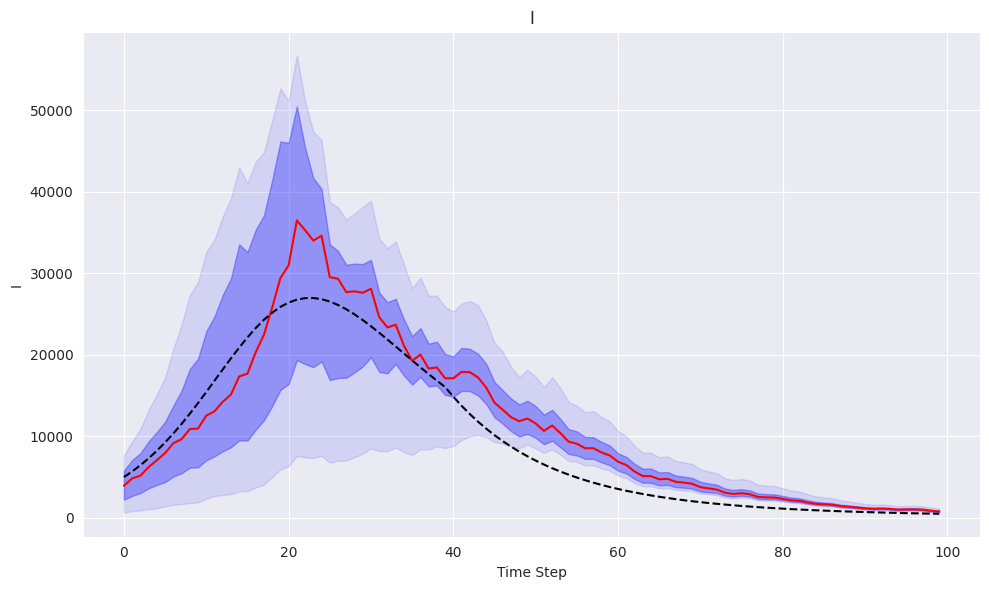

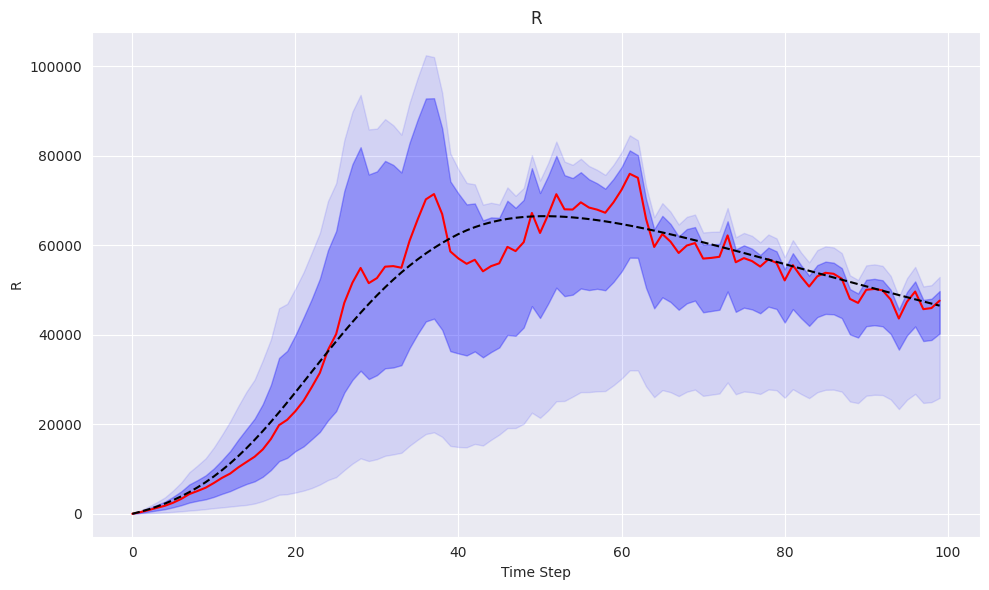

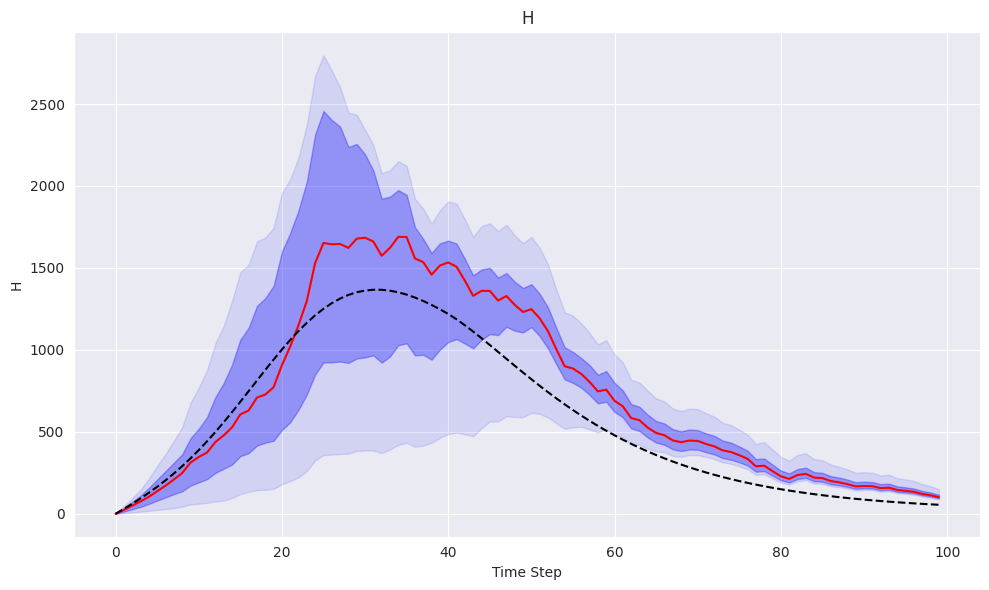

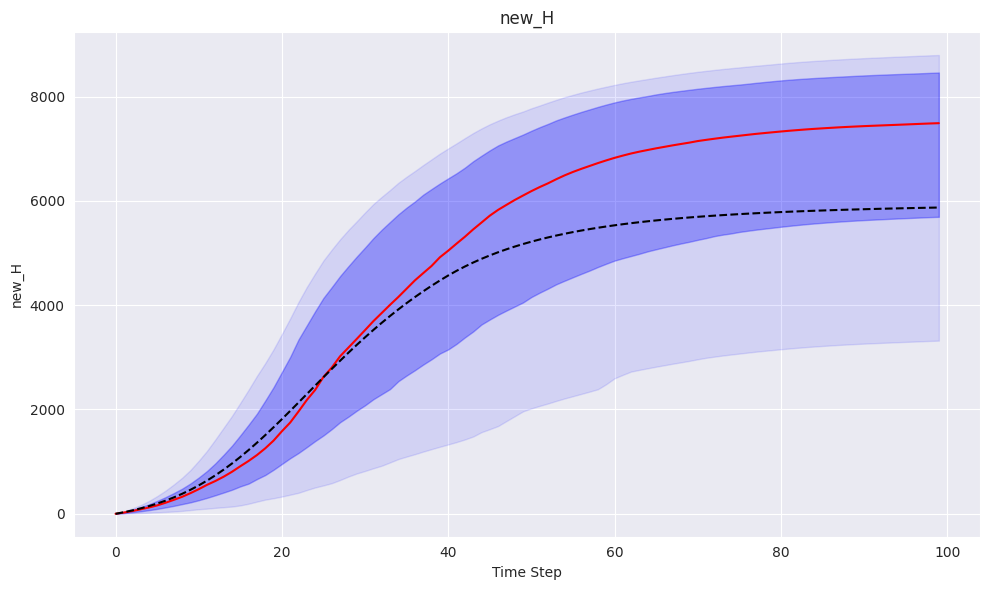

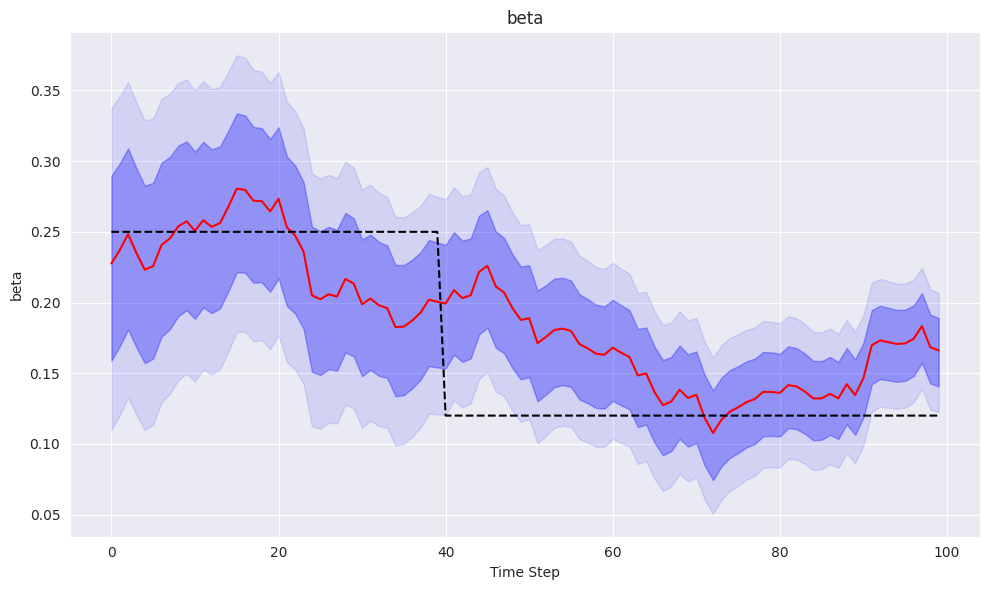

In [11]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Number of particles, state variables, and time steps
N, S, T = states.shape

state_labels = ["S", "I", "R", "H", "new_H", "beta"]

quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]

# Plot each state variable separately
for i in range(S):
    variable_data = states[:, i, :]  # Shape (N, T)

    quantile_values = np.percentile(variable_data, [q * 100 for q in quantiles], axis=0)

    plt.figure(figsize=(10, 6))

    # Fill areas between quantiles
    plt.fill_between(
        np.arange(T), quantile_values[0], quantile_values[-1], color="blue", alpha=0.1
    )
    plt.fill_between(
        np.arange(T), quantile_values[1], quantile_values[-2], color="blue", alpha=0.3
    )
    plt.plot(np.arange(T), quantile_values[2], color="red")  # Median
    plt.plot(np.arange(T), true_data[i, :], color="black", linestyle="--")  # true data

    plt.title(state_labels[i])
    plt.xlabel("Time Step")
    plt.ylabel(state_labels[i])

    plt.tight_layout()
    plt.show()
    plt.close()